# 1. Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import keras
import tensorflow
import pickle
import seaborn as sns
import time
import matplotlib
import pickle
import pyltr
import datetime
import decimal

import matplotlib.pyplot as plt
from IPython.display import display

# 2. Reading data

In [74]:
hotel = pd.read_csv('hotel.csv')

In [75]:
journey = pd.read_csv('journey.csv')

In [76]:
feedback = pd.read_csv('feedback.csv')

# 3 Cleaning up
Dropping misleading info like rows which contain **check-in dates before the booking** and **check-out dates before check-in**. Tables are updated to keep working with them.

In [77]:
journey = journey[journey['booking_date'] <= journey['checkin_date']] #Because they can reserve in the same day

In [78]:
journey = journey[journey['checkin_date'] < journey['checkout_date']]

## 3.1 Check relevant NaNs
Do the data sets contain lots of missing values?

In [133]:
print("Missing values for Journey:")
display(journey.isna().sum())
print("-----------------------------")
print("Missing values for Journey:")
display(hotel.isna().sum())
print("-----------------------------")
print("Missing values for Journey:")
display(feedback.isna().sum())
print("-----------------------------")

Missing values for Journey:


journey_id         0
booking_date       0
checkin_date       0
checkout_date      0
ota_id             0
language         248
is_in_app        248
item_id            0
dtype: int64

-----------------------------
Missing values for Journey:


item_id              0
city                 0
country              0
stars                0
room_count        7960
overall_liking    1393
based_on             0
hotel_type_id        0
dtype: int64

-----------------------------
Missing values for Journey:


time          0
journey_id    0
question      0
answer        0
dtype: int64

-----------------------------


According to the results, the **feedback** dataset has 248 rows whose "language" value is missing. Same happens to the boolean feature "is_in_app". After checking the raw dataset, these (unexpectedly) seem to be related, i.e., we don't know the guest's language when we don't know if the app is used for booking or not.

## 3.2 Histograms of date related info
Section dedicated to inspect the data hidden in the **date** variable.

In [153]:
def plotter(df, key, title, per_day = False, sort = False, a = 15, b = 7):
    """
    df -- DataFrame to work with
    key -- 'str' variable to search for in df
    title -- 'str' name to add on top of the resulting plot
    per_day -- boolean to indicate if we want the result per month or per day
    
    returns: None
    result: Shows a plot
    """
    plt.rcParams['figure.figsize'] = [a, b]
    
    if per_day:
        df1 = pd.to_datetime(df[key]).dt.day
    else:
        df1 = pd.to_datetime(df[key]).dt.month
        
    df1.value_counts(sort = sort).plot(kind='bar', title = title)

By taking the date of the **journey** dataset, we can extract the high season by displaying the month when the check-ins are made. As seen in the results below, *May is the preferred month, followed by April, March, June and Feburary (ordered in descending mode)*. The rest of the months are not even present.

Later, we will see this mode might be due to the country the hotel is located in. As most of them are located in the northern hemisphere or in hot areas, users probabply book their logding for summer holidays.

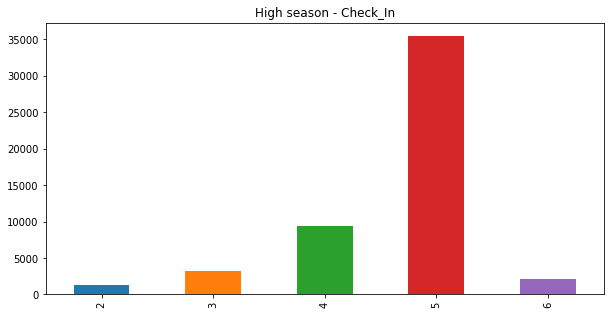

In [154]:
plotter(journey, 'checkin_date', "High season - Check_In", a = 10, b = 5)

Reviewing the booking date, we can see a relation between the date the room has been booked in and the check-in date (hence we have the same 'high season'). **How much in advance do the Users book the rooms then?** We will see it in a moment.

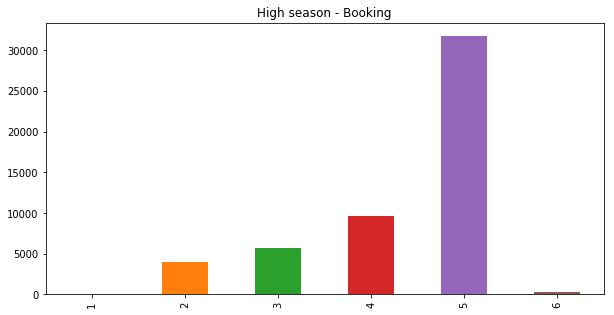

In [155]:
plotter(journey, 'booking_date', "High season - Booking", a = 10, b = 5)

#### Interesting insight 1 - The periods of booking depend slightly on  the date
Next plot provides another point of view to the booking season, as it is shown by day. There is no significant mode on the day people prefer to book, altough there are some mentions:
* The beginning (1), the middle (14) and the end (30) of the month show peaks, which might be related to the day people get their salary, hence having money for (small) vacations.
* There is a decrease on bookings on the dates that fall in between the peak dates, namely, dates around the 10th and the 23rd. Based on the statement from the point above, we can say people wait some time to book, maybe to find a better offer.
* Since we have booking data of 6 months (February to June), the number of months with 30 and 31 days are equal, therefore the results on the plot are valid.

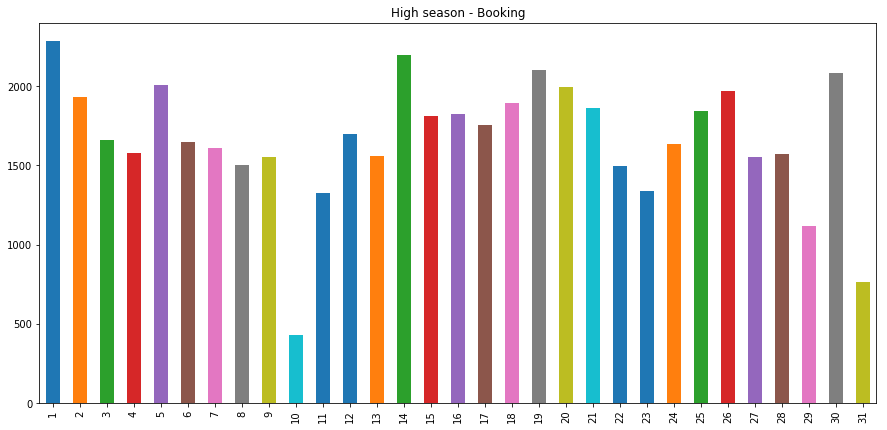

In [156]:
plotter(journey, 'booking_date', "High season - Booking", per_day = True)

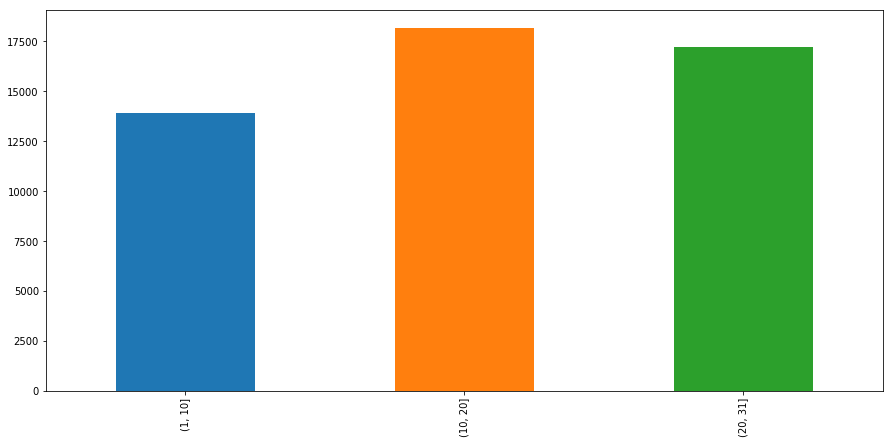

In [157]:
# When do the people make the booking?
# booking_period = pd.to_datetime(journey['booking_date']).dt.day
# pd.cut(booking_period, bins = [1, 10, 20, 31]).value_counts(sort = False).plot(kind='bar')

Returning to the question: **How much in advance do the Users book the rooms then?** Interestingly, most people book the hotel the same day they check-in, probably on the spot. This fact does not fully support the *Interesting insight 1*, since it would require a planning prior vacantion booking. However, we do se users who booked their room long time ago, reaching values of even 115 days (almost 4 months) before. Data about the money each User paid would've given us if this helped saving money or not.

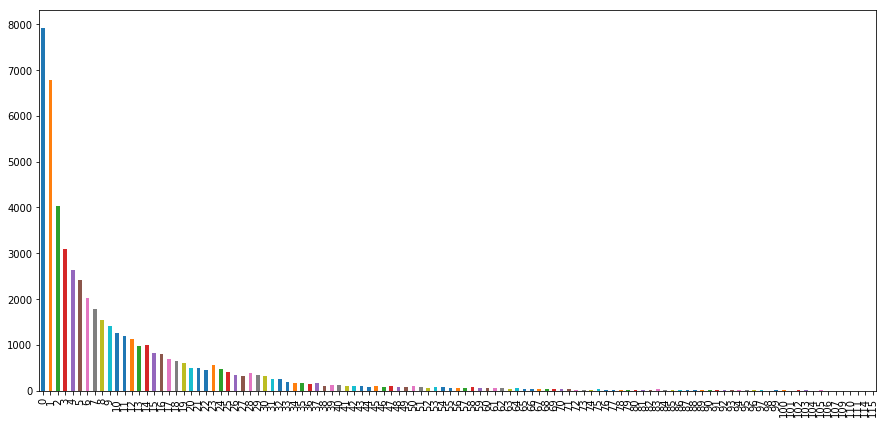

In [169]:
#Calculates days from booking to check-in
from_book_to_stay = pd.to_datetime(journey['checkin_date']) - pd.to_datetime(journey['booking_date'])
from_book_to_stay.dt.days.value_counts(sort = True).sort_index().plot(kind='bar')

In [170]:
def print_length_stay(df):
    """
    df -- DataFrame to work with

    returns: None
    result: Shows a plot
    """
    length_of_stay = pd.to_datetime(df['checkout_date']) - pd.to_datetime(df['checkin_date'])
    length_of_stay.dt.days.value_counts(sort = True).plot(kind='bar')

## 3.2 Trivago App
#### Interesting insight 2 - The app is not used that much
At first sight, many "FALSE" values are present in the 'is_in_app' variable. After a simple check, we can calculate that only 248 out of 5134500 users book the rooms through the app, leading to a 0.48% of success. Plotting the difference takes us to a high inbalance. This means either the data collected does not represent the population, or that users truly do not use the app.

('App success rate: ', Decimal('0.4830071087739799396241114033'))


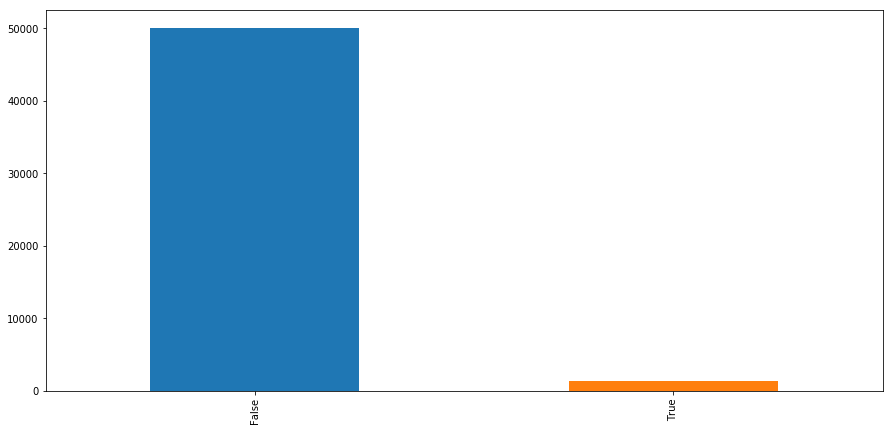

In [178]:
app_NaNs = journey['is_in_app'].isna().sum()
total_entries = journey['is_in_app'].count()
rate_NaNs = decimal.Decimal(app_NaNs) / decimal.Decimal(total_entries) * decimal.Decimal(100)
print("App success rate: ", rate_NaNs)

journey['is_in_app'].value_counts().plot(kind='bar')

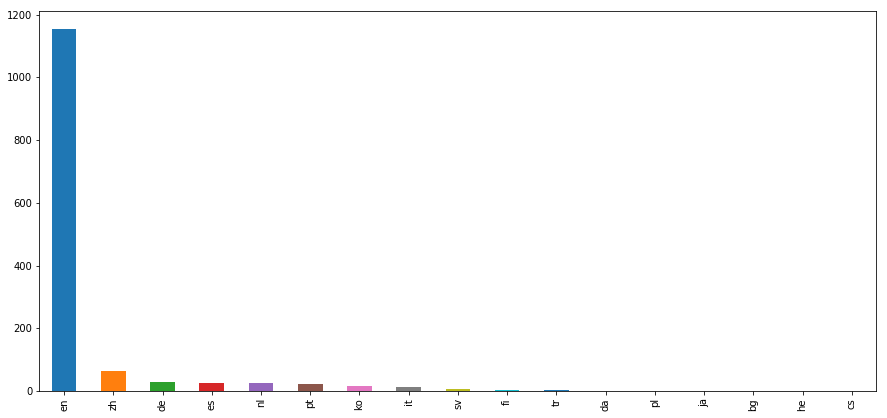

In [182]:
# Occurences of languages (21 available)
app_journey = journey[journey['is_in_app'] == True]
app_journey['language'].value_counts().plot(kind='bar')

## 3.3 Joining Tables

### 3.3.1 Check time to feedback
#### Interesting insight 3 - Users give the feedback after the first 24h
The time users take to give the feedback is between the 24-48 hours. Still, most of them also review their stay in the first 24 hours, and others after 48 hours. As time passes by, the users either forgot, or think is too late to do it. Even natural human procrastination acts here, this might be why we have such late results.

This is shown in the plot from this section. Ranges on the x axis indicate 24-hour ranges. Only the overall plot is shown for simplicity (commented lines of code filter the types of questions), but each individual type of question has been checked to be sure there is not an unbalance that might mask the results.

In [220]:
#Join tables by common id
journey_feedback = journey.join(feedback.set_index('journey_id'), on='journey_id')

In [221]:
#Take only the ones that have review
journey_feedback_only = journey_feedback[journey_feedback['answer'].isna() == False]

In [222]:
#journey_feedback_only = journey_feedback_only[journey_feedback_only['question'] == 'question.open_feedback']
#journey_feedback_only = journey_feedback_only[journey_feedback_only['question'] == 'question.staff_rating']
#journey_feedback_only = journey_feedback_only[journey_feedback_only['question'] == 'question.overall_rating']

In [232]:
def get_time_to_feedback(df, key1, key2, title, amount = 15):
    dates = pd.to_datetime(df[key1]) - pd.to_datetime(df[key2])
    dates = dates.dropna()
    hourly = lambda x: x.total_seconds() / 3600.0
    dates = dates.apply(hourly).round()
    pd.cut(dates, bins = range(0, 1992, 24)).value_counts(sort = False).head(amount).plot(kind='bar', title = title)

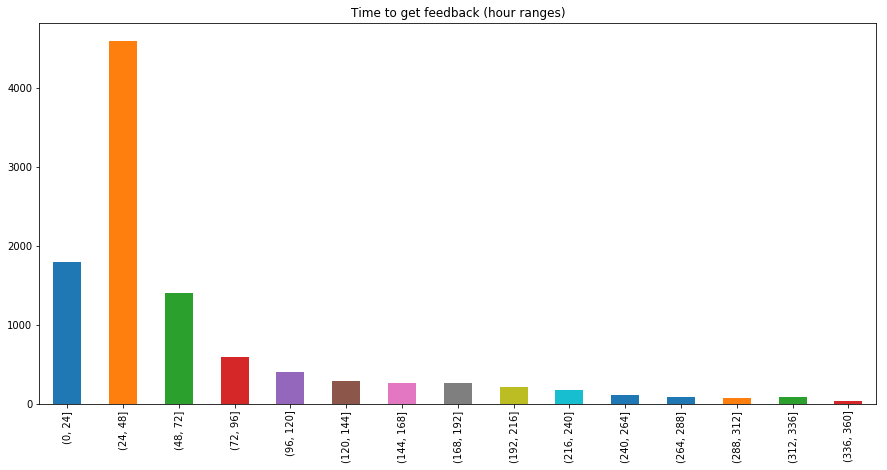

In [234]:
get_time_to_feedback(journey_feedback_only, 'time', 'checkout_date', "Time to get feedback (hour ranges)")

#### Interesting insight 4 - The feedback response time does not depend on the satisfaction
**Is this delay related to the satisfaction of the client?** After checking the rates ('answer') given by the users, we see that the pattern remains the same, i.e., it doesn't matter if the rate is high or low, the response time tends to be the same.

(For this conclusion, I have assumed the "question.overall_rating" includes all kind of feedback.)

In [248]:
#Assuming overall includes staff
def get_of_rate(df, x):
    df = df[df['question'] == 'question.overall_rating']
    return df[df['answer'] == x]

In [249]:
def print_length_stay(df):
    length_of_stay = pd.to_datetime(df['checkout_date']) - pd.to_datetime(df['checkin_date'])
    length_of_stay.dt.days.value_counts(sort = True).plot(kind='bar')

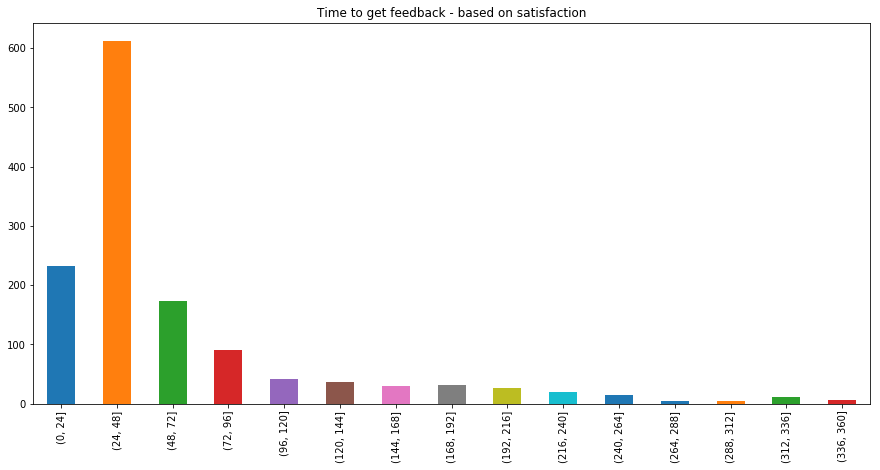

In [250]:
#Relation: Time to deliver the feedback - satisfaction
get_time_to_feedback(get_of_rate(journey_feedback, '5'), 'time', 'checkout_date', "Time to get feedback - based on satisfaction")

## 3.4 Hotels
#### Interesting insight 5 - Rate of Trivago and User rate are different
There is not a relation between a hotel having more stars, the rate given by Trivago and the rate calculated based on User feedback. Each of them deliver a different ranking of the countries as seen in the 3 plots below in this section.

In [253]:
#Join tables
journey_hotel = journey.join(hotel.set_index('item_id'), on='item_id')

In [276]:
#Remove journesy with no hotel matched
journey_hotel = journey_hotel[journey_hotel['hotel_type_id'].isna() == False]

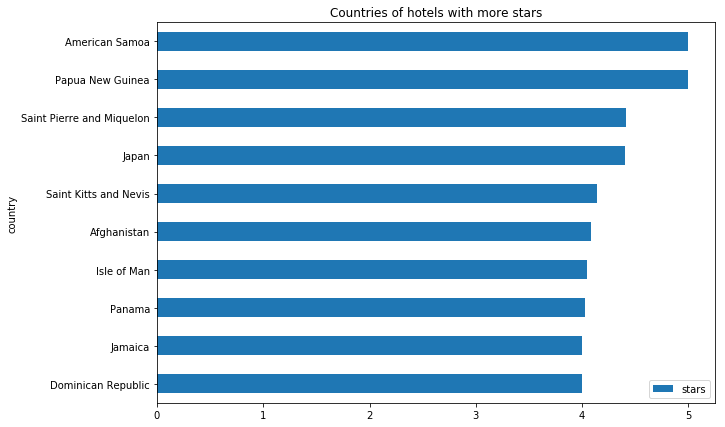

In [277]:
#Countries of Hotels with most stars
hotel_stars = pd.DataFrame(hotel.groupby('country').mean()['stars'])
hotel_stars.sort_values(by = 'stars').tail(10).plot(kind='barh', figsize = (10, 7), title = "Countries of hotels with more stars")

In [278]:
#Join all tables
allInfo = journey_hotel.join(feedback.set_index('journey_id'), on='journey_id')

In [279]:
#Replacing text values and NaNs to better work with the data.
allInfo = allInfo.replace('text data', -1) #Text data
allInfo['answer'] = allInfo['answer'].fillna(-2) #NaN Data
allInfo['answer'] = allInfo['answer'].astype('int64')

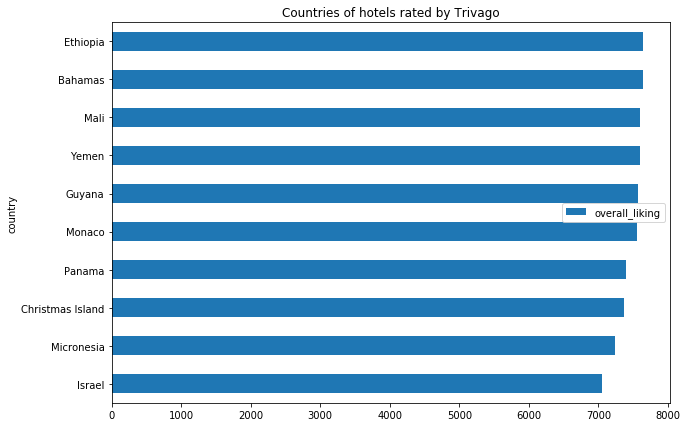

In [280]:
# Checks countries with highest overall_rating
allInfo_ratings = pd.DataFrame(allInfo.groupby('country').mean()['overall_liking'])
allInfo_ratings = allInfo_ratings[allInfo_ratings['overall_liking'].isna() == False]
allInfo_ratings.sort_values(by = 'overall_liking').head(10).plot(kind='barh', figsize = (10, 7), title = "Countries of hotels rated by Trivago")

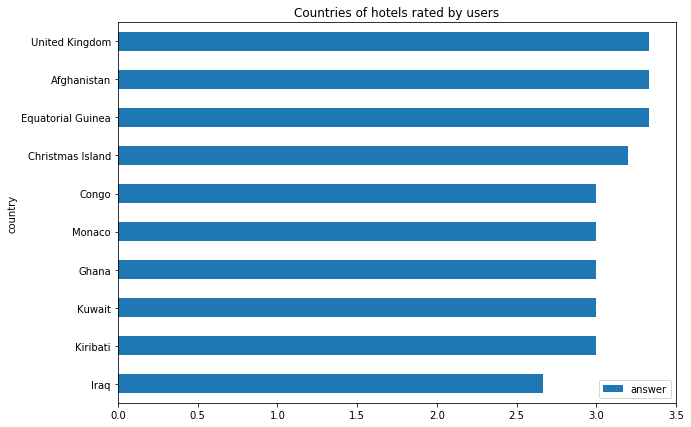

In [282]:
# Checks countries with highest rate by the user
allInfo_answers = allInfo[allInfo['answer'].isna() == False]
allInfo_answers = allInfo_answers[allInfo_answers['question'] == 'question.overall_rating']

allInfo_answers[allInfo_answers['answer'].isna() == False]
allInfo_answers['answer'] = allInfo_answers['answer'].astype('int64')

allInfo_answers = pd.DataFrame(allInfo_answers.groupby('country').mean()['answer'])
allInfo_answers.sort_values(by = 'answer').head(10).plot(kind='barh', figsize = (10, 7), title = "Countries of hotels rated by users")